In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (16.0, 8.0)})
plt.rcParams.update({'font.size': 14})
import pickle

<font size=6> <font color='green'>  The algorithm mainly discussed in this notebook is Random Forest </font> </font>



#### DATA

In [5]:
data = pd.read_csv("creditcard.csv")
col_names = list(data.columns)
data = data.drop_duplicates()
X = data.drop("Class",axis=1)
y = data.Class
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=.2,random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
del data

In [6]:
col_names.remove("Class")

#### MODELS

In [7]:
lr = pickle.load(open("lr_model_fraude.pkl","rb"))
rf = pickle.load(open("rf_model_fraude.pkl","rb"))
#svm = pickle.load(open("svmBest_model_fraude.pkl","rb"))

### Logistic Regression

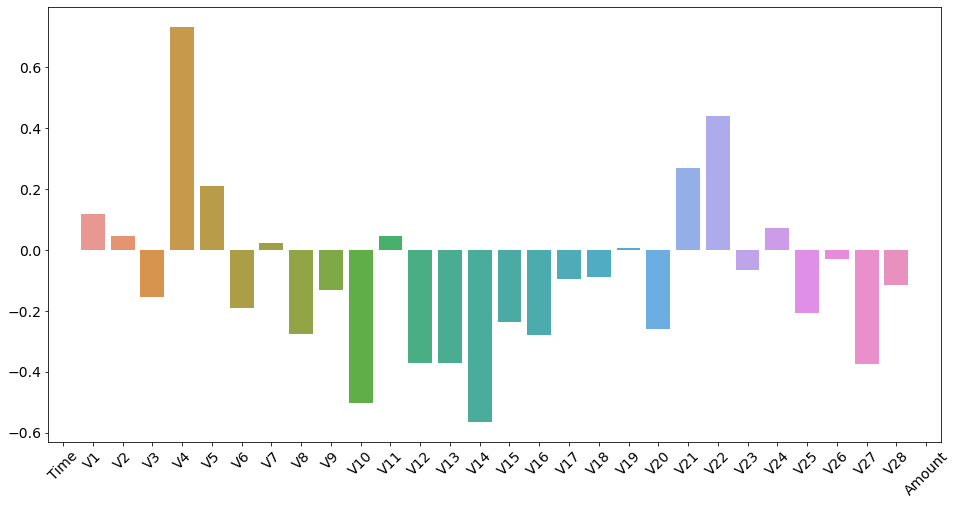

In [20]:
sns.barplot(x=col_names, y=lr.coef_.flatten())
plt.xticks(rotation= 45);

Logistic regression coef :
 - Here we can notice that `Time`and `Amount`variable have almost no influence on the decision.
 - The most influencial variable in the logistic regression model decision is `V4`
 - Other influencial variables are `V10`,`V14`
 - Almost all the variables have a mean influence on the decision

### Random Forest with Shap

In [32]:
X_test = pd.DataFrame(X_test,columns=col_names)

In [25]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [111]:
# Shap values are computed for each class
# Interest is on fraudulent operations : class 1
class_idx = 1
print(shap_values[class_idx].shape)

In [112]:
# getting fraudulent op idx :
fraude_idx = np.array(np.where(y_test==1)).flatten()
print(fraude_idx[:10])

##### --------------    Local features importance   --------------

  In the test sample, this is 95 fraudulent operations. Lets focus on only fraudulent operations in this analysis.

In [104]:
print("max idx = {}".format(len(fraude_idx)-1))

max idx = 94


In [100]:
fraud_1 = fraude_idx[0]
shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx][fraud_1,:], X_test.iloc[fraud_1,:])

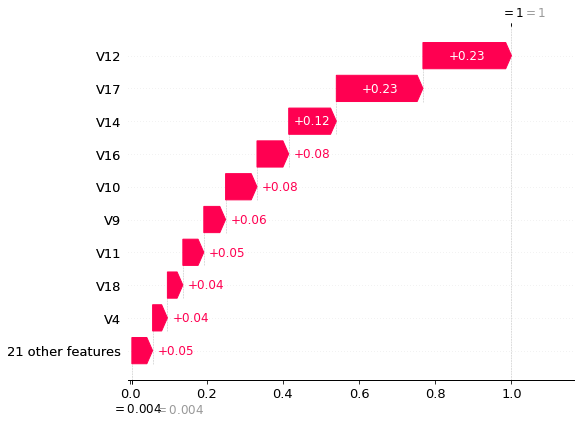

In [101]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[class_idx],
                                       shap_values[class_idx][fraud_1,:],
                                       feature_names=col_names)

It can be noticed that here the most influencial variable on the decision is V12. As soon as we don't have any information on this variable, we can't search for a practical explanation of its relationship with fraud.

In [92]:
print("max idx = {}".format(len(fraude_idx)-1))

max idx = 94


In [102]:
fraud_2 = fraude_idx[88]

shap.force_plot(explainer.expected_value[class_idx],
                shap_values[class_idx][fraud_2,:], X_test.iloc[fraud_2,:])

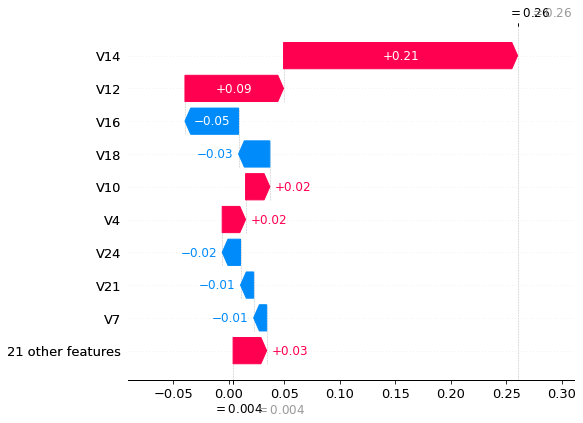

In [103]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[class_idx],
                                       shap_values[class_idx][fraud_2,:],
                                       feature_names=col_names)

 Here `V14` and `V12` are the main variable that put a big influence in the decision to classify this input as fraudulent.
 Some variables as `V16` are also use to ""constest the probability to be a fraudulent operation""

In [105]:
fraud_3 = fraude_idx[86]

shap.force_plot(explainer.expected_value[class_idx],
                shap_values[class_idx][fraud_3,:], X_test.iloc[fraud_3,:])

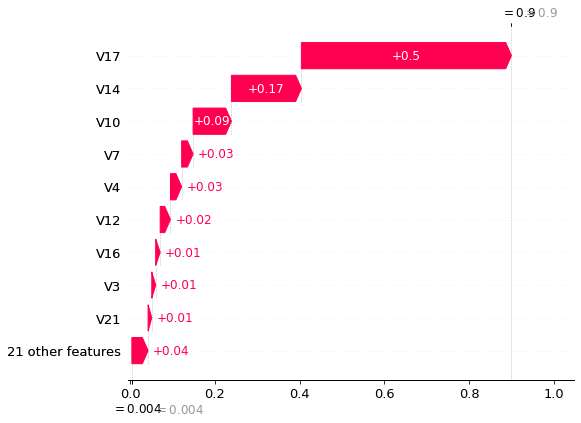

In [106]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[class_idx],
                                       shap_values[class_idx][fraud_3,:],
                                       feature_names=col_names)

For this three specific examples, `V12`,`V14` and `V17` are the main three variables that determine if an the operation is fraudulent or not.\
Let's take a global look of the features impact.

##### --------------    Global features importance   --------------

 ###### Fraudulent operations : class 1

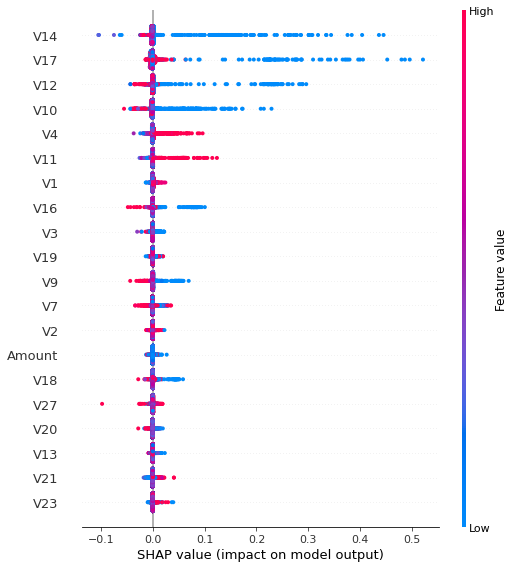

In [108]:
class_idx = 1
shap.summary_plot(shap_values[class_idx], X_test,feature_names = col_names)

###### Regular operations : class 0

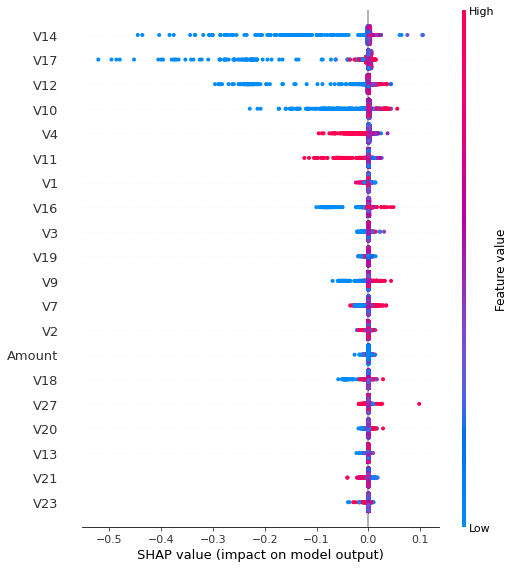

In [109]:
class_idx= 0
shap.summary_plot(shap_values[class_idx], X_test,feature_names = col_names)

##### Conclusion on random forest :
We saw in the MLdetection notebook that the Random Forest Classifier was one of the best that shows good performance on the test dataset. This classifier is effective in differentiating regular transactions from fraudulent transactions.

To make decisions, it mainly uses the variables V14, V17 and V12 to determine whether a transaction is fraudulent or not.

In [ ]:
# for svm and logistic regression use

In [ ]:
X_train_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(svm,X_train_summary)
shap_values = explainer.shap_values(X_test)